In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf

import glob
import sys
import os
from collections import OrderedDict

import csv

sys.path.insert(0, "../hcr-ff/")
from plot_utils import *
from genome_utils import *

In [2]:
# Guide score files
F1R1_fn = '../data/FASTQ/FADS1_rep8detailed.txt'
F1R2_fn = '../data/FASTQ/FADS1_rep9detailed.txt'

F2R1_fn = '../data/FASTQ/FADS2_rep8detailed.txt'
F2R2_fn = '../data/FASTQ/FADS2_rep11detailed.txt'

F3R1_fn = '../data/FASTQ/FADS3_rep7detailed.txt'
F3R2_fn = '../data/FASTQ/FADS3_rep8detailed.txt'

FnR1_fn = '../data/FASTQ/FEN1_rep11detailed.txt'
FnR2_fn = '../data/FASTQ/FEN1_rep12detailed.txt'

fn_list = [F1R1_fn,F1R2_fn,F2R1_fn,F2R2_fn,
           F3R1_fn,F3R2_fn,FnR1_fn,FnR2_fn]

exp_ids = ['F1R1','F1R2','F2R1','F2R2',
           'F3R1','F3R2','FnR1','FnR2']

fullinfo= [("FADS1",1), ("FADS1",2), ("FADS2",1), ("FADS2",2), 
           ("FADS3",1), ("FADS3",2), ("FEN1",1), ("FEN1",2)]

id2info = { exp_id: info for exp_id, info in zip(exp_ids, fullinfo) }

id2info['k27'] = ('H3K27ac', 1)
id2info['DHS'] = ('DHS', 1)

In [3]:
# Peak BED files
# MAINTAIN ORDER (see exp_ids variable above)
F1R1_bed= '../data/FADS1_rep8__fixPeaks.bed'
F1R2_bed= '../data/FADS1_rep9__fixPeaks.bed'

F2R1_bed= '../data/FADS2_rep8__rescore_fixPeaks.bed'
F2R2_bed= '../data/FADS2_rep11__rescore_fixPeaks.bed'

F3R1_bed= '../data/FADS3_rep7__rescore_fixPeaks.bed'
F3R2_bed= '../data/FADS3_rep8__rescore_fixPeaks.bed'

FnR1_bed= '../data/FEN1_rep11__rescore_fixPeaks.bed'
FnR2_bed= '../data/FEN1_rep12__rescore_fixPeaks.bed'

exp_beds= [F1R1_bed, F1R2_bed, F2R1_bed, F2R2_bed, 
           F3R1_bed, F3R2_bed, FnR1_bed, FnR2_bed]

K27_bed = '../data/k27ac_replicatePeaks_hg38_scoreFiltered.bed'
DHS_bed = '../data/DNASE_peaks_replicated.bed'

extra_beds = [ K27_bed, DHS_bed ]
extra_tags = [ 'k27', 'DHS' ]

In [4]:
gff = pd.read_table('../data/FADS_locus.gff')

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [5]:
gff

,name,chrom,strand,txStart,txEnd,cdsStart,cdsEnd,exonCount,exonStarts,exonEnds,geneID
0,ENST00000542506.5,chr11,-,61802312,61815291,61802410,61813305,12,"61802312,61802800,61803031,61803362,61803669,6...","61802462,61802926,61803111,61803459,61803767,6...",FADS1
1,ENST00000257261.10,chr11,+,61816255,61867354,61816285,61865689,12,"61816255,61837777,61840333,61840623,61848158,6...","61816426,61837888,61840531,61840725,61848284,6...",FADS2
2,ENST00000305885.3,chr11,+,61792910,61797238,61795361,61796504,2,"61792910,61795340","61793028,61797238",FEN1
3,ENST00000278829.7,chr11,-,61873525,61891545,61873813,61891381,12,"61873525,61875850,61876110,61876358,61876865,6...","61873865,61875976,61876190,61876455,61876963,6...",FADS3


In [6]:
data = []
for i, fn in enumerate(fn_list):
    d_pt = pd.read_table(fn,sep='\t',header=0)
    ## Rescale to floats
    rescale = min(d_pt['LS_reads'].sum(),d_pt['HS_reads'].sum()) / d_pt.loc[:,('HS_reads','LS_reads')].sum(axis=0)
    d_pt.loc[:,('HS_reads','LS_reads')] *= rescale
    ## Sample downsized library
    runif              = np.random.uniform(size=d_pt.loc[:,('HS_reads','LS_reads')].shape)
    int_part, sample_p = np.divmod( d_pt.loc[:,('HS_reads','LS_reads')], 1 )
    d_pt.loc[:,('HS_reads','LS_reads')] = int_part + (runif < sample_p)
    ## Return as int
    d_pt.loc[:,('HS_reads','LS_reads')] = d_pt.loc[:,('HS_reads','LS_reads')].astype(int) + 1
    d_pt[exp_ids[i]] = np.log( d_pt['LS_reads'] / d_pt['HS_reads'] )
    data.append( d_pt.loc[((~d_pt['Coordinates'].str.contains("NT")) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-LV2')) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-SgO'))),
                          ('Coordinates',exp_ids[i])] )

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
data = pd.concat([ df.set_index('Coordinates') for df in data ],axis=1)

In [8]:
data['cutsite'] = [ int(coord.split(':')[1].split('-')[1]) - 4 
                      if coord.split(':')[-1] == '+' 
                      else 
                    int(coord.split(':')[1].split('-')[0]) + 3 
                      for coord in data.index ]

In [9]:
# Get experimental peaks
## Read in files
test_peaks = [ pd.read_table(
                 fn,sep='\t',header=None,
                 names=['chr','start','end','hdr','pass','strand']
               ) 
               for fn in exp_beds ]
## Figure out which chromosomes were tested
tested_chr = pd.concat( test_peaks, axis=0 )['chr'].unique()
## Filter out non-significant peaks
test_peaks = [ merge_bed(
                   df.loc[ df['pass'] == True, ('chr','start','end') ].copy()
               )
               for df in test_peaks ]

print("Experimental track count: {}".format(len(test_peaks)))

# Add on extra features from ENCODE
## Read in files
extra_feat = [ pd.read_table(fn,sep='\t',header=None,
                             names=['chr','start','end'],usecols=[0,1,2]) 
               for fn in extra_beds ]
## Filter out un-tested chromosomes for speed
chr_filters = [ np.vstack([feat['chr'] == chrom for chrom in tested_chr ]).any(axis=0) 
                for feat in extra_feat ]

# Combine
[ test_peaks.append( feat.loc[ chr_filter ,:] ) for feat, chr_filter in zip(extra_feat, chr_filters) ]
test_peaks = [ df.reset_index(drop=True) for df in test_peaks ]
print("Total track count: {}".format(len(test_peaks)))
for exp_id, peaks_idx in zip(exp_ids+extra_tags,range(len(test_peaks))):
    test_peaks[peaks_idx]['exp_id'] = exp_id
    test_peaks[peaks_idx]['assay'] = id2info[exp_id][0]
    test_peaks[peaks_idx]['replicate'] = id2info[exp_id][1]
    
test_peaks = pd.concat(test_peaks,axis=0,ignore_index=True)


Experimental track count: 8
Total track count: 10


/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: read_table is deprecated, use read_csv instead.
  import sys
/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: read_table is deprecated, use read_csv instead.


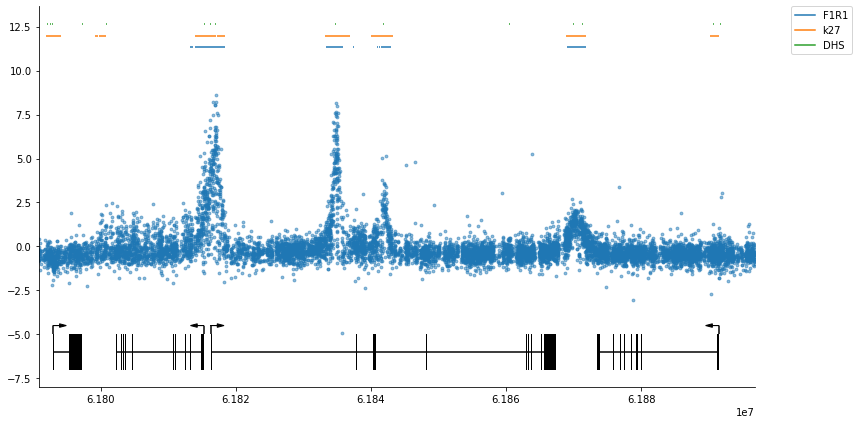

In [10]:
fig_h = plot_hff_cutsites(np.array([[61790805,61896817]]), 
                  data, test_peaks, plot_ids=['F1R1','k27','DHS'])
draw_genes_from_gff(fig_h[1], gff)

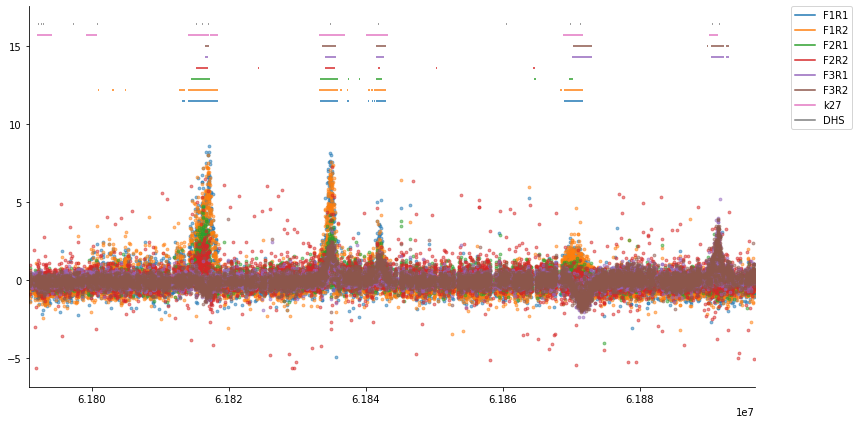

In [11]:
fig_h = plot_hff_cutsites(np.array([[61790805,61896817]]), 
                  data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','k27','DHS'])


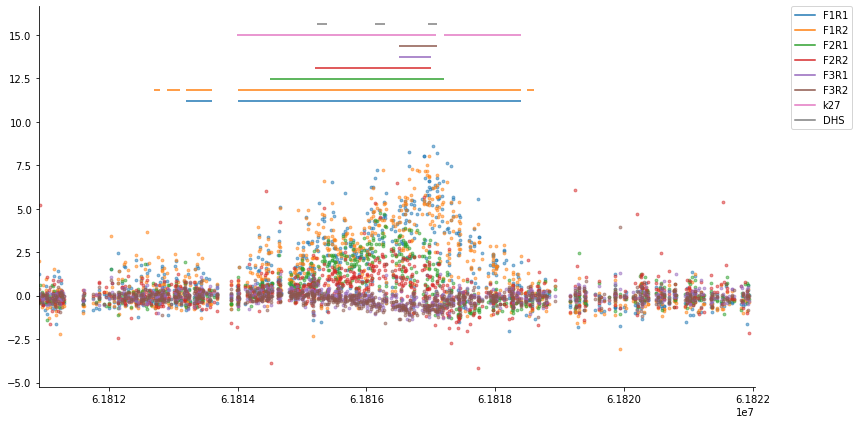

In [12]:
fig_h = plot_hff_cutsites(np.array([[61810908,61822034]]), 
                  data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','k27','DHS'])


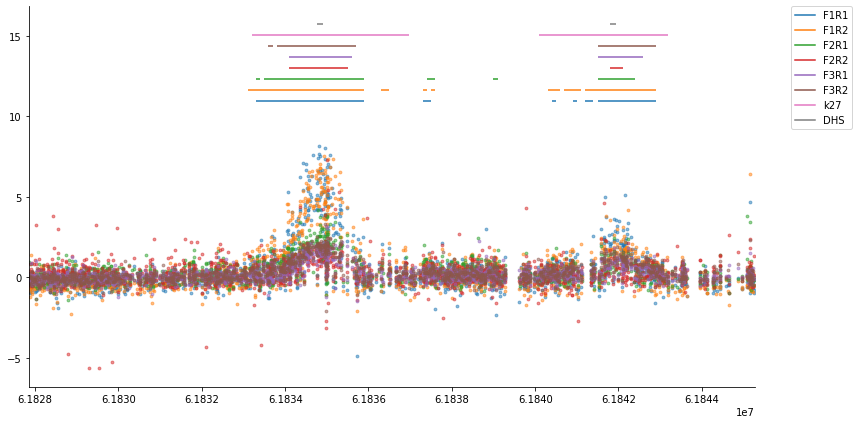

In [13]:
fig_h = plot_hff_cutsites(np.array([[61827852,61845270]]), 
                  data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','k27','DHS'])


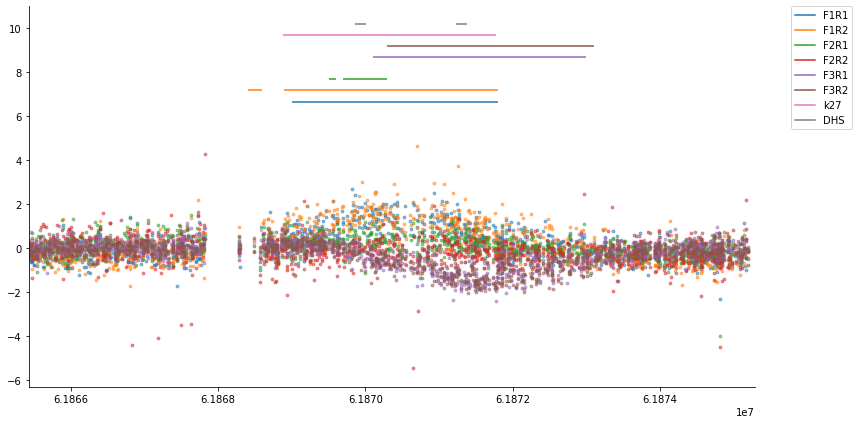

In [14]:
fig_h = plot_hff_cutsites(np.array([[61865430,61875290]]), 
                  data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','k27','DHS'])


FADS1
2
FADS2
0
FADS3
5
FEN1
2


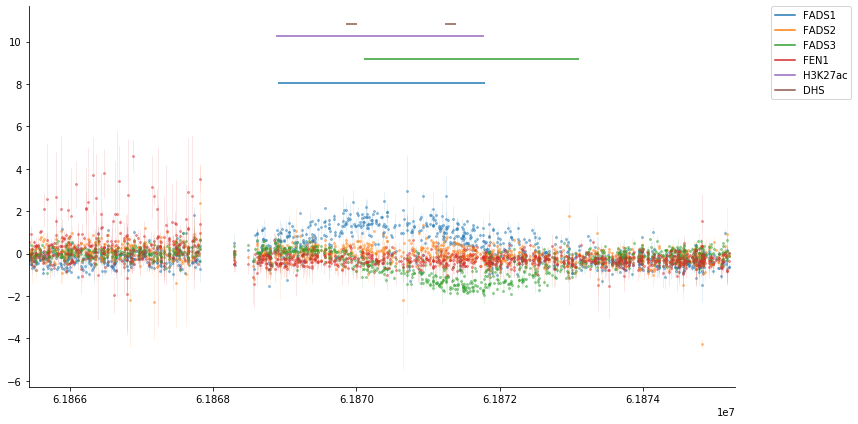

In [15]:
fig_h, ax_h = plot_combined_cutsites(np.array([[61865430,61875290]]), 
          data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','FnR1','FnR2','k27','DHS'])
fig_h.savefig('FADS_locus__61865430_61875290__all.pdf')

FADS1
2
FADS2
0
FADS3
5


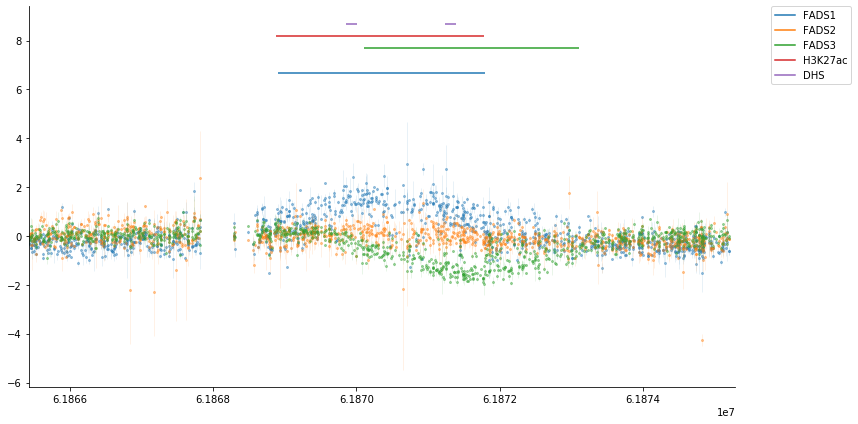

In [16]:
fig_h, ax_h = plot_combined_cutsites(np.array([[61865430,61875290]]), 
          data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','k27','DHS'])
fig_h.savefig('FADS_locus__61865430_61875290__noFEN1.pdf')

FADS1
11
FADS2
9
FADS3
24


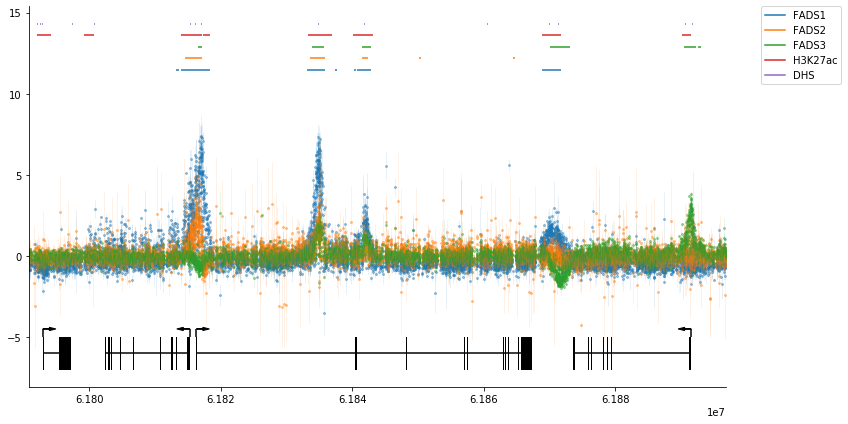

In [17]:
fig_h, ax_h = plot_combined_cutsites(np.array([[61790805,61896817]]), 
                  data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','k27','DHS'])

draw_genes_from_gff(ax_h, gff)


FADS1
11
FADS2
9
FADS3
24
FEN1
48


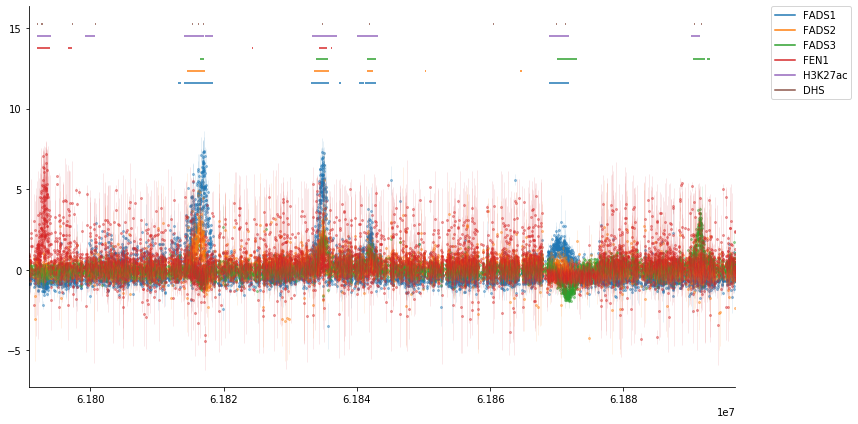

In [18]:
fig_h, ax_h = plot_combined_cutsites(np.array([[61790805,61896817]]), 
                  data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','FnR1','FnR2','k27','DHS'])


FADS1
11


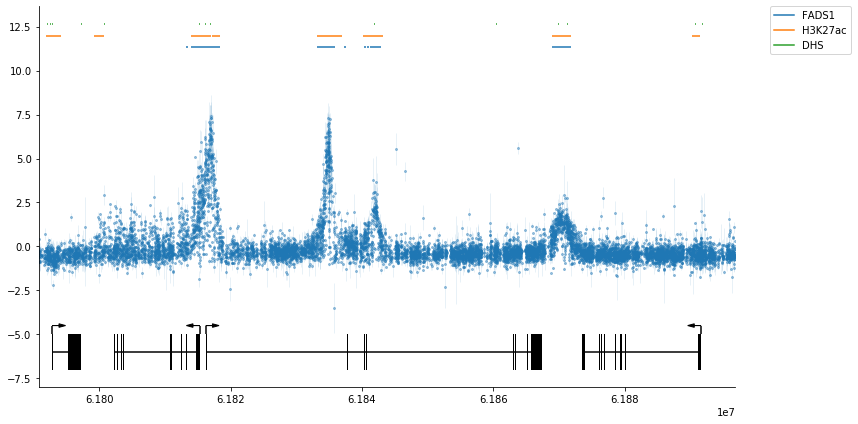

In [19]:
fig_h, ax_h = plot_combined_cutsites(np.array([[61790805,61896817]]), 
                  data, test_peaks, plot_ids=['F1R1','F1R2','k27','DHS'])

draw_genes_from_gff(ax_h, gff)

FADS2
9


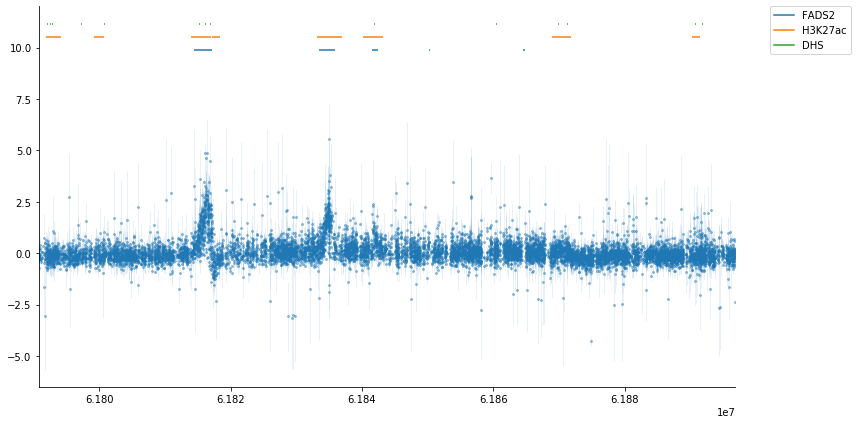

In [20]:
fig_h, ax_h = plot_combined_cutsites(np.array([[61790805,61896817]]), 
                  data, test_peaks, plot_ids=['F2R1','F2R2','k27','DHS'])


FADS3
24


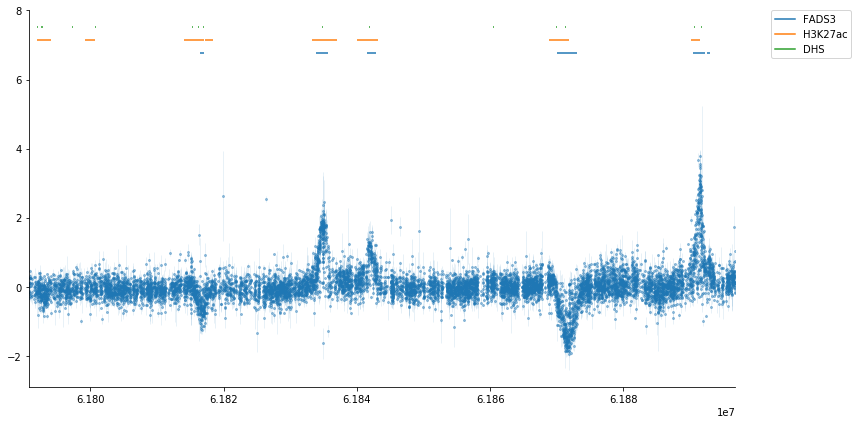

In [21]:
fig_h, ax_h = plot_combined_cutsites(np.array([[61790805,61896817]]), 
                  data, test_peaks, plot_ids=['F3R1','F3R2','k27','DHS'])


FEN1
48


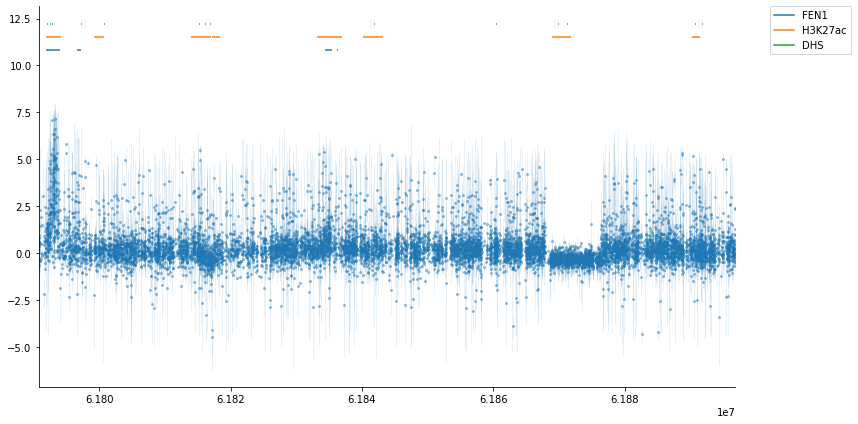

In [22]:
fig_h, ax_h = plot_combined_cutsites(np.array([[61790805,61896817]]), 
                  data, test_peaks, plot_ids=['FnR1','FnR2','k27','DHS'])


FADS1
1
FADS2
1
FADS3
1


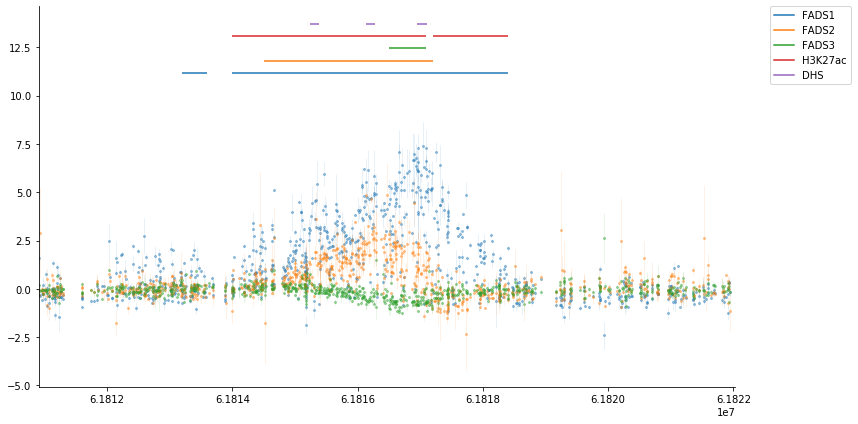

In [23]:
fig_h, ax_h = plot_combined_cutsites(np.array([[61810908,61822034]]), 
          data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','k27','DHS'])
fig_h.savefig('FADS_locus__61810908_61822034__noFEN1.pdf')

FADS1
1
FADS2
4
FADS3
5


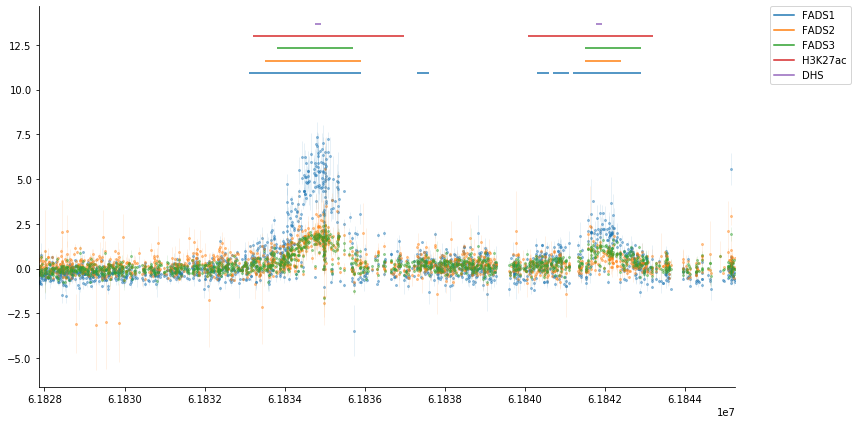

In [24]:
fig_h, ax_h = plot_combined_cutsites(np.array([[61827852,61845270]]), 
          data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','k27','DHS'])
fig_h.savefig('FADS_locus__61827852_61845270__noFEN1.pdf')

# Connection diagram

In [25]:
txn_starts = extract_txn_starts(gff)

In [26]:
all_locus_peaks = get_replicating_peaks(test_peaks)

In [27]:
# FADS1
FADS1_rep1_scores = pd.read_table('../data/FADS1_rep8__fixPeaks.bed',header=None,
                                  names=['chr','start','end','hdr','pass','strand'])
FADS1_rep1_scores['score'] = [ np.array(interval.split(',')).astype(float).mean() 
                               for interval in FADS1_rep1_scores['hdr'] ]

FADS1_rep1_scores['score'] = FADS1_rep1_scores['score'] - FADS1_rep1_scores['score'].median()

FADS1_rep2_scores = pd.read_table('../data/FADS1_rep9__fixPeaks.bed',header=None,
                                  names=['chr','start','end','hdr','pass','strand'])
FADS1_rep2_scores['score'] = [ np.array(interval.split(',')).astype(float).mean() 
                               for interval in FADS1_rep2_scores['hdr'] ]

FADS1_rep2_scores['score'] = FADS1_rep2_scores['score'] - FADS1_rep2_scores['score'].median()

FADS1_total_scores = FADS1_rep1_scores.copy()
FADS1_total_scores['pass'] = (FADS1_rep1_scores['pass'] & FADS1_rep2_scores['pass'])
FADS1_total_scores['score'] = (FADS1_rep1_scores['score'] + FADS1_rep2_scores['score']) / 2

# FADS2
FADS2_rep1_scores = pd.read_table('../data/FADS2_rep8__rescore_fixPeaks.bed',header=None,
                                  names=['chr','start','end','hdr','pass','strand'])
FADS2_rep1_scores['score'] = [ np.array(interval.split(',')).astype(float).mean() 
                               for interval in FADS2_rep1_scores['hdr'] ]

FADS2_rep1_scores['score'] = FADS2_rep1_scores['score'] - FADS2_rep1_scores['score'].median()

FADS2_rep2_scores = pd.read_table('../data/FADS2_rep11__rescore_fixPeaks.bed',header=None,
                                  names=['chr','start','end','hdr','pass','strand'])
FADS2_rep2_scores['score'] = [ np.array(interval.split(',')).astype(float).mean() 
                               for interval in FADS2_rep2_scores['hdr'] ]

FADS2_rep2_scores['score'] = FADS2_rep2_scores['score'] - FADS2_rep2_scores['score'].median()

FADS2_total_scores = FADS2_rep1_scores.copy()
FADS2_total_scores['pass'] = (FADS2_rep1_scores['pass'] & FADS2_rep2_scores['pass'])
FADS2_total_scores['score'] = (FADS2_rep1_scores['score'] + FADS2_rep2_scores['score']) / 2

# FADS3
FADS3_rep1_scores = pd.read_table('../data/FADS3_rep7__rescore_fixPeaks.bed',header=None,
                                  names=['chr','start','end','hdr','pass','strand'])
FADS3_rep1_scores['score'] = [ np.array(interval.split(',')).astype(float).mean() 
                               for interval in FADS3_rep1_scores['hdr'] ]

FADS3_rep1_scores['score'] = FADS3_rep1_scores['score'] - FADS3_rep1_scores['score'].median()

FADS3_rep2_scores = pd.read_table('../data/FADS3_rep8__rescore_fixPeaks.bed',header=None,
                                  names=['chr','start','end','hdr','pass','strand'])
FADS3_rep2_scores['score'] = [ np.array(interval.split(',')).astype(float).mean() 
                               for interval in FADS3_rep2_scores['hdr'] ]

FADS3_rep2_scores['score'] = FADS3_rep2_scores['score'] - FADS3_rep2_scores['score'].median()

FADS3_total_scores = FADS3_rep1_scores.copy()
FADS3_total_scores['pass'] = (FADS3_rep1_scores['pass'] & FADS3_rep2_scores['pass'])
FADS3_total_scores['score'] = (FADS3_rep1_scores['score'] + FADS3_rep2_scores['score']) / 2

# FEN1
FEN1_rep1_scores = pd.read_table('../data/FEN1_rep11__rescore_fixPeaks.bed',header=None,
                                  names=['chr','start','end','hdr','pass','strand'])
FEN1_rep1_scores['score'] = [ np.array(interval.split(',')).astype(float).mean() 
                               for interval in FEN1_rep1_scores['hdr'] ]

FEN1_rep1_scores['score'] = FEN1_rep1_scores['score'] - FEN1_rep1_scores['score'].median()

FEN1_rep2_scores = pd.read_table('../data/FEN1_rep12__rescore_fixPeaks.bed',header=None,
                                  names=['chr','start','end','hdr','pass','strand'])
FEN1_rep2_scores['score'] = [ np.array(interval.split(',')).astype(float).mean() 
                               for interval in FEN1_rep2_scores['hdr'] ]

FEN1_rep2_scores['score'] = FEN1_rep2_scores['score'] - FEN1_rep2_scores['score'].median()

FEN1_total_scores = FEN1_rep1_scores.copy()
FEN1_total_scores['pass'] = (FEN1_rep1_scores['pass'] & FEN1_rep2_scores['pass'])
FEN1_total_scores['score'] = (FEN1_rep1_scores['score'] + FEN1_rep2_scores['score']) / 2



/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  # Remove the CWD from sys.path while we load stuff.
/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
/home

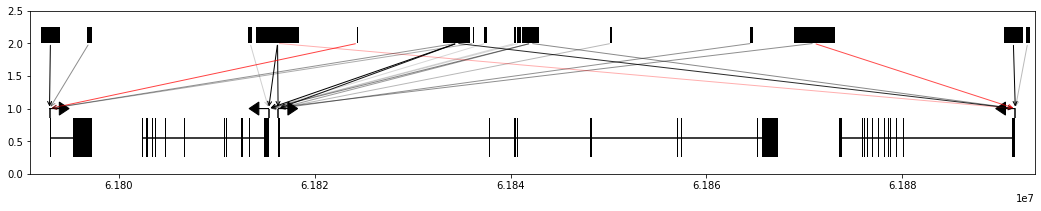

In [28]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
ax.set_xlim( gff_to_locus_lims(gff,0.02) )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, promoter_params=[1000,0.2,1000], gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS1'], y_anchor=2.0, y_target=1.0, score_bed=FADS1_total_scores)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS2'], y_anchor=2.0, y_target=1.0, score_bed=FADS2_total_scores)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS3'], y_anchor=2.0, y_target=1.0, score_bed=FADS3_total_scores)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FEN1'], y_anchor=2.0, y_target=1.0, score_bed=FEN1_total_scores)

plt.savefig('FADS_locus__full_locus__connectogram.pdf')

plt.show()

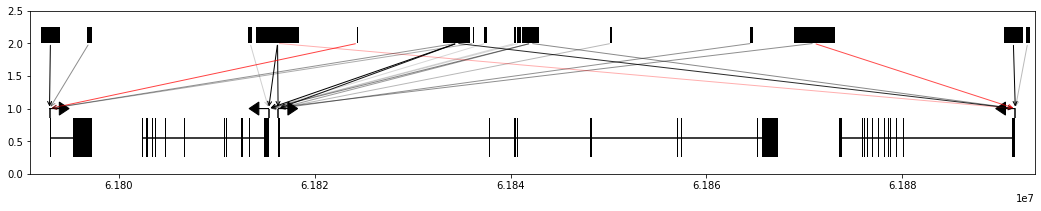

In [29]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
ax.set_xlim( gff_to_locus_lims(gff,0.02) )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, promoter_params=[1000,0.2,1000], gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS1'], y_anchor=2.0, y_target=1.0, score_bed=FADS1_total_scores)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS2'], y_anchor=2.0, y_target=1.0, score_bed=FADS2_total_scores)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS3'], y_anchor=2.0, y_target=1.0, score_bed=FADS3_total_scores)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FEN1'], y_anchor=2.0, y_target=1.0, score_bed=FEN1_total_scores)
plt.show()

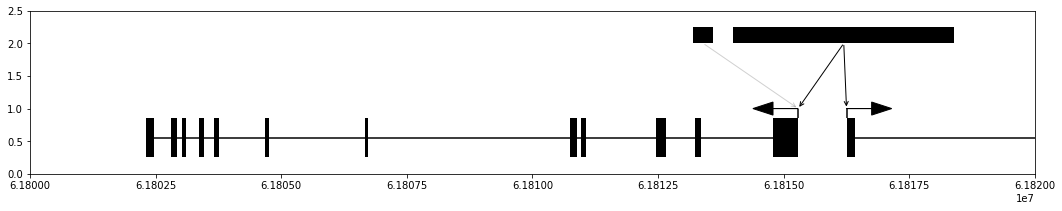

In [30]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
glims = [61800000,61820000]
ax.set_xlim( *glims )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, promoter_params=[500,0.2,400], gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS1'], y_anchor=2.0, y_target=1.0, score_bed=FADS1_total_scores, xlims=glims)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS2'], y_anchor=2.0, y_target=1.0, score_bed=FADS2_total_scores, xlims=glims)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS3'], y_anchor=2.0, y_target=1.0, score_bed=FADS3_total_scores, xlims=glims)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FEN1'], y_anchor=2.0, y_target=1.0, score_bed=FEN1_total_scores, xlims=glims)

plt.savefig('FADS_locus__61800000_61820000__connectogram.pdf')

plt.show()

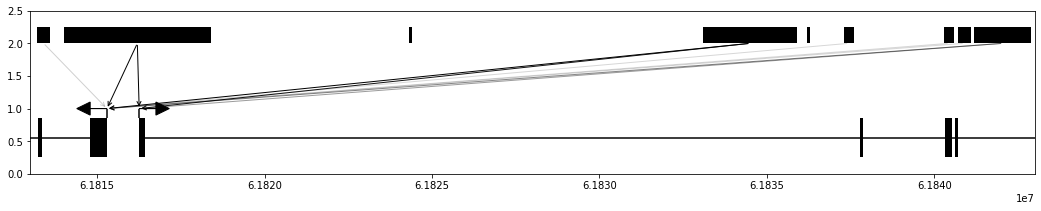

In [31]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
glims = [61813000,61843000]
ax.set_xlim( *glims )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, promoter_params=[500,0.2,400], gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS1'], y_anchor=2.0, y_target=1.0, score_bed=FADS1_total_scores, xlims=glims)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS2'], y_anchor=2.0, y_target=1.0, score_bed=FADS2_total_scores, xlims=glims)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS3'], y_anchor=2.0, y_target=1.0, score_bed=FADS3_total_scores, xlims=glims)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FEN1'], y_anchor=2.0, y_target=1.0, score_bed=FEN1_total_scores, xlims=glims)

plt.savefig('FADS_locus__61813000_61843000__connectogram.pdf')

plt.show()

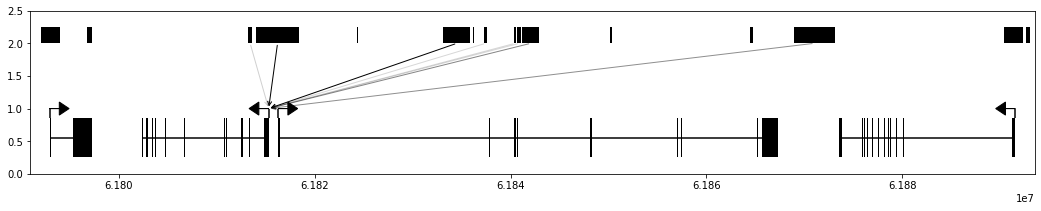

In [32]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
ax.set_xlim( gff_to_locus_lims(gff,0.02) )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS1'], y_anchor=2.0, y_target=1.0, score_bed=FADS1_total_scores)

plt.savefig('FADS1__full_locus__connectogram.pdf')

plt.show()

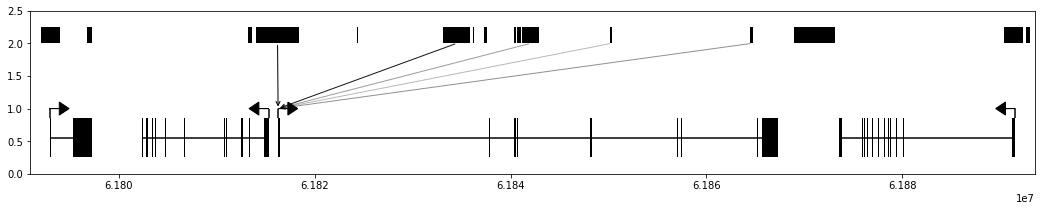

In [33]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
ax.set_xlim( gff_to_locus_lims(gff,0.02) )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS2'], y_anchor=2.0, y_target=1.0, score_bed=FADS2_total_scores)

plt.savefig('FADS2__full_locus__connectogram.pdf')

plt.show()

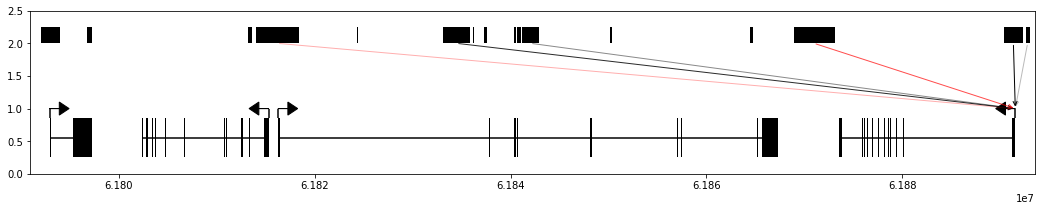

In [34]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
ax.set_xlim( gff_to_locus_lims(gff,0.02) )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS3'], y_anchor=2.0, y_target=1.0, score_bed=FADS3_total_scores)

plt.savefig('FADS3__full_locus__connectogram.pdf')

plt.show()

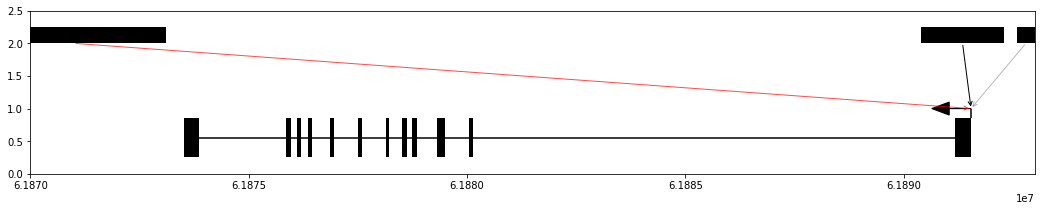

In [35]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
glims = [61870000,61893000]
ax.set_xlim( *glims )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, promoter_params=[500,0.2,400], gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
#connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS1'], y_anchor=2.0, y_target=1.0, score_bed=FADS1_total_scores, xlims=glims)
#connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS2'], y_anchor=2.0, y_target=1.0, score_bed=FADS2_total_scores, xlims=glims)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS3'], y_anchor=2.0, y_target=1.0, score_bed=FADS3_total_scores, xlims=glims)
#connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FEN1'], y_anchor=2.0, y_target=1.0, score_bed=FEN1_total_scores, xlims=glims)

plt.savefig('FADS_locus__61863000_61893000__connectogram.pdf')

plt.show()

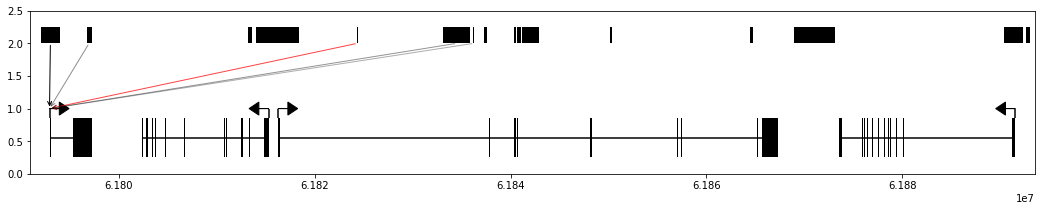

In [36]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
ax.set_xlim( gff_to_locus_lims(gff,0.02) )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FEN1'], y_anchor=2.0, y_target=1.0, score_bed=FEN1_total_scores)

plt.savefig('FEN1__full_locus__connectogram.pdf')

plt.show()

# Effector directionality analysis

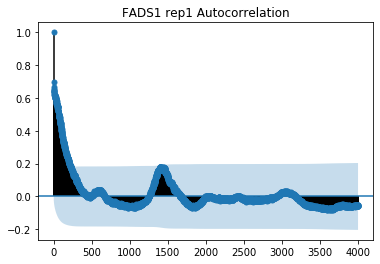

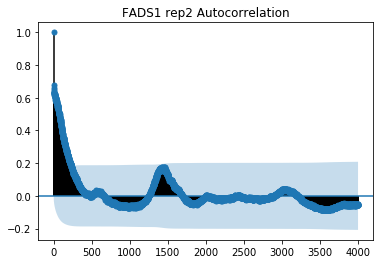

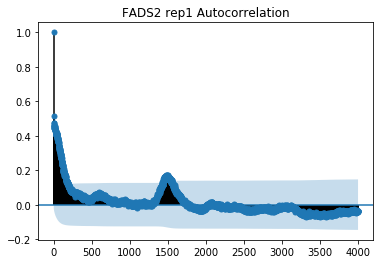

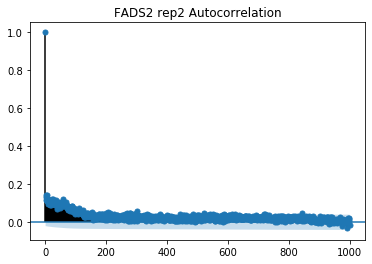

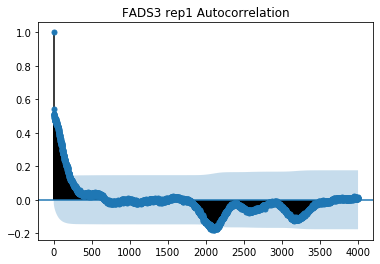

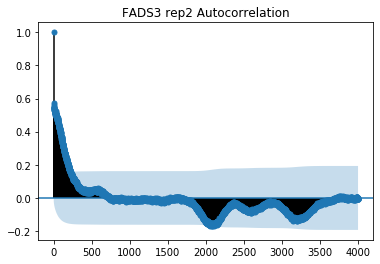

In [37]:
plot_acf( data['F1R1'], lags=4000, title='FADS1 rep1 Autocorrelation' )
plt.savefig('FADS1_rep1__autocorrelation.pdf')
plt.show()
plot_acf( data['F1R2'], lags=4000, title='FADS1 rep2 Autocorrelation' );
plt.savefig('FADS1_rep2__autocorrelation.pdf')
plt.show()
plot_acf( data['F2R1'], lags=4000, title='FADS2 rep1 Autocorrelation' );
plt.savefig('FADS2_rep1__autocorrelation.pdf')
plt.show()
plot_acf( data['F2R2'], lags=1000, title='FADS2 rep2 Autocorrelation' );
plt.savefig('FADS2_rep2__autocorrelation.pdf')
plt.show()
plot_acf( data['F3R1'], lags=4000, title='FADS3 rep1 Autocorrelation' );
plt.savefig('FADS3_rep1__autocorrelation.pdf')
plt.show()
plot_acf( data['F3R2'], lags=4000, title='FADS3 rep2 Autocorrelation' );
plt.savefig('FADS3_rep2__autocorrelation.pdf')
plt.show()


In [38]:
pos_strand = [ True if ':+' in x else False for x in data.index ]
neg_strand = [ True if ':-' in x else False for x in data.index ]

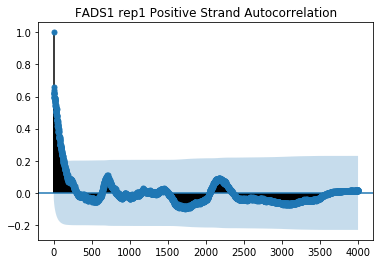

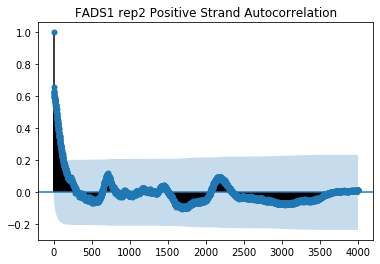

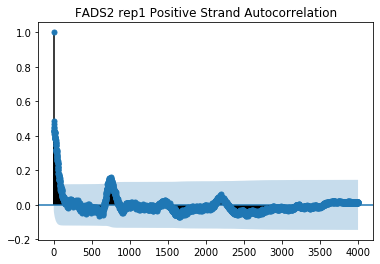

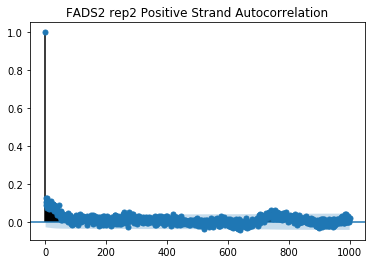

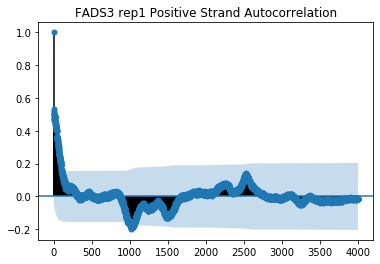

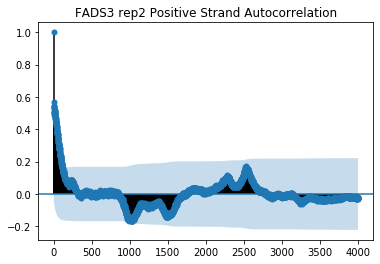

In [39]:
plot_acf( data.loc[pos_strand,'F1R1'], lags=4000, title='FADS1 rep1 Positive Strand Autocorrelation' )
plt.savefig('FADS1_rep1_pos__autocorrelation.pdf')
plt.show()
plot_acf( data.loc[pos_strand,'F1R2'], lags=4000, title='FADS1 rep2 Positive Strand Autocorrelation' );
plt.savefig('FADS1_rep2_pos__autocorrelation.pdf')
plt.show()
plot_acf( data.loc[pos_strand,'F2R1'], lags=4000, title='FADS2 rep1 Positive Strand Autocorrelation' );
plt.savefig('FADS2_rep1_pos__autocorrelation.pdf')
plt.show()
plot_acf( data.loc[pos_strand,'F2R2'], lags=1000, title='FADS2 rep2 Positive Strand Autocorrelation' );
plt.savefig('FADS2_rep2_pos__autocorrelation.pdf')
plt.show()
plot_acf( data.loc[pos_strand,'F3R1'], lags=4000, title='FADS3 rep1 Positive Strand Autocorrelation' );
plt.savefig('FADS3_rep1_pos__autocorrelation.pdf')
plt.show()
plot_acf( data.loc[pos_strand,'F3R2'], lags=4000, title='FADS3 rep2 Positive Strand Autocorrelation' );
plt.savefig('FADS3_rep2_pos__autocorrelation.pdf')
plt.show()


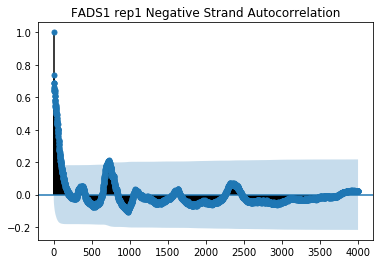

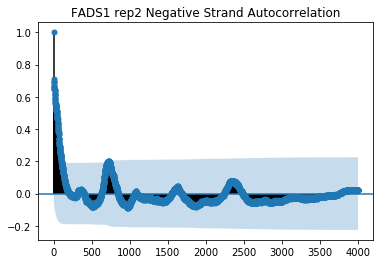

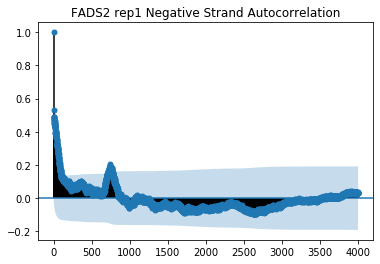

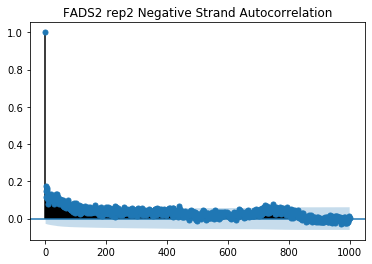

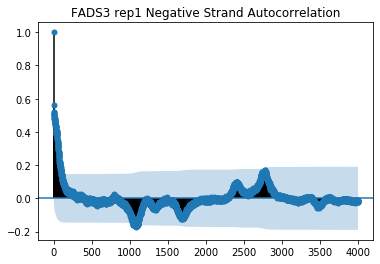

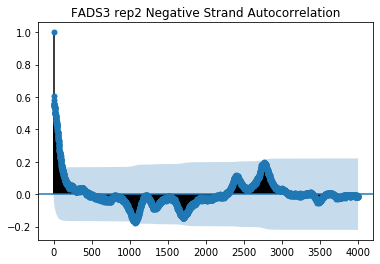

In [40]:
plot_acf( data.loc[neg_strand,'F1R1'], lags=4000, title='FADS1 rep1 Negative Strand Autocorrelation' )
plt.savefig('FADS1_rep1_neg__autocorrelation.pdf')
plt.show()
plot_acf( data.loc[neg_strand,'F1R2'], lags=4000, title='FADS1 rep2 Negative Strand Autocorrelation' );
plt.savefig('FADS1_rep2_neg__autocorrelation.pdf')
plt.show()
plot_acf( data.loc[neg_strand,'F2R1'], lags=4000, title='FADS2 rep1 Negative Strand Autocorrelation' );
plt.savefig('FADS2_rep1_neg__autocorrelation.pdf')
plt.show()
plot_acf( data.loc[neg_strand,'F2R2'], lags=1000, title='FADS2 rep2 Negative Strand Autocorrelation' );
plt.savefig('FADS2_rep2_neg__autocorrelation.pdf')
plt.show()
plot_acf( data.loc[neg_strand,'F3R1'], lags=4000, title='FADS3 rep1 Negative Strand Autocorrelation' );
plt.savefig('FADS3_rep1_neg__autocorrelation.pdf')
plt.show()
plot_acf( data.loc[neg_strand,'F3R2'], lags=4000, title='FADS3 rep2 Negative Strand Autocorrelation' );
plt.savefig('FADS3_rep2_neg__autocorrelation.pdf')
plt.show()


FADS1
1


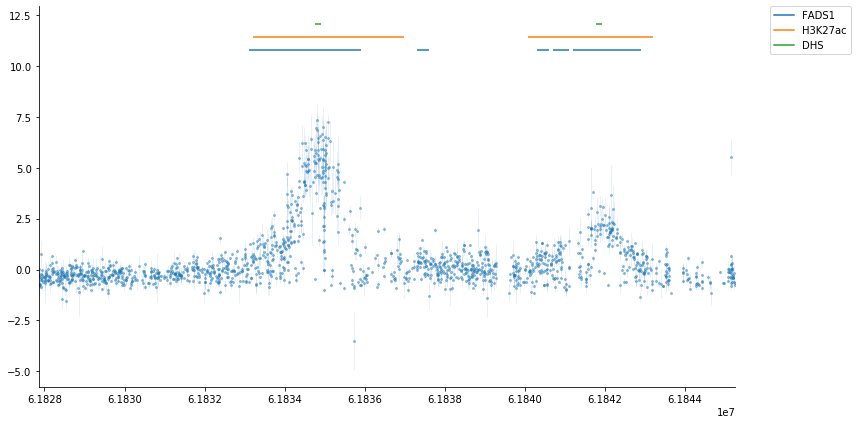

In [41]:
fig_h, ax_h = plot_combined_cutsites(np.array([[61827852,61845270]]), 
          data, test_peaks, plot_ids=['F1R1','F1R2','k27','DHS'])
fig_h.savefig('FADS_locus__61827852_61845270__noFEN1.pdf')

In [42]:
data['strand'] = [ x.split(':')[-1] for x in data.index ]

In [43]:
data

,F1R1,F1R2,F2R1,F2R2,F3R1,F3R2,FnR1,FnR2,cutsite,strand
Coordinates,,,,,,,,,,
chr11:61788524-61788546:-,-0.444506,-0.717688,-0.446532,-0.424917,-0.208681,-0.215305,0.093006,0.597376,61788527,-
chr11:61788527-61788549:-,-0.585573,-0.444525,0.149400,-0.064382,-0.342047,-0.060320,-0.542184,0.874229,61788530,-
chr11:61788560-61788582:+,-0.414482,-0.325180,-0.753205,-0.218902,-0.108891,-0.073516,-0.351929,0.512321,61788578,+
chr11:61788568-61788590:+,-0.803122,-0.090514,-0.185422,0.295908,-0.304052,-0.410123,0.498659,0.100331,61788586,+
chr11:61788568-61788590:-,-0.682111,-1.205913,-0.347912,-0.037850,-0.265037,-0.103503,1.012557,0.526470,61788571,-
chr11:61788583-61788605:-,-1.074896,-0.293761,-0.324383,0.029612,0.318587,0.171850,-0.013606,0.606533,61788586,-
chr11:61788622-61788644:+,0.054382,-0.559616,-0.361578,0.025064,-0.301970,-0.009917,0.422857,0.572311,61788640,+
chr11:61788630-61788652:+,-0.498486,-0.488097,0.161138,-0.121361,0.040588,0.324861,5.288267,-4.110874,61788648,+
chr11:61788645-61788667:-,-0.792547,-1.033473,-0.401473,-0.349295,-0.039817,-0.619039,2.616834,1.248847,61788648,-


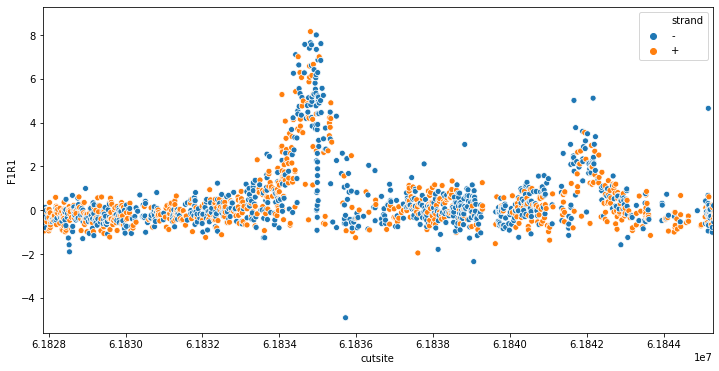

In [44]:
fig = plt.figure(figsize=(12,6))
ax = sns.scatterplot(data=data,x='cutsite',y='F1R1',hue='strand')
ax.set_xlim([61827852,61845270])
fig.savefig('FADS_locus__strandeffectsFADS1.pdf')
plt.show()

# Subsetting analysis

In [45]:
S0R1_fn = '../data/FASTQ/FADS1_rep8detailed.txt'
S1R1_fn = 'subset_10__FADS1_rep8detailed.txt'
S2R1_fn = 'subset_20__FADS1_rep8detailed.txt'
S3R1_fn = 'subset_30__FADS1_rep8detailed.txt'
S4R1_fn = 'subset_40__FADS1_rep8detailed.txt'
S5R1_fn = 'subset_50__FADS1_rep8detailed.txt'
S6R1_fn = 'subset_60__FADS1_rep8detailed.txt'
S7R1_fn = 'subset_70__FADS1_rep8detailed.txt'
S8R1_fn = 'subset_80__FADS1_rep8detailed.txt'
S9R1_fn = 'subset_90__FADS1_rep8detailed.txt'

fn_list = [S0R1_fn,S1R1_fn,S2R1_fn,S3R1_fn,S4R1_fn,
           S5R1_fn,S6R1_fn,S7R1_fn,S8R1_fn,S9R1_fn]

exp_ids = ['S0R1','S1R1','S2R1','S3R1','S4R1',
           'S5R1','S6R1','S7R1','S8R1','S9R1']

fullinfo= [("Sub00",1), ("Sub10",1), ("Sub20",1), ("Sub30",1), ("Sub40",1), 
           ("Sub50",1), ("Sub60",1), ("Sub70",1), ("Sub80",1), ("Sub90",1)]

id2info = { exp_id: info for exp_id, info in zip(exp_ids, fullinfo) }

id2info['k27'] = ('H3K27ac', 1)
id2info['DHS'] = ('DHS', 1)

In [46]:
data = []
for i, fn in enumerate(fn_list):
    d_pt = pd.read_table(fn,sep='\t',header=0)
    ## Rescale to floats
    rescale = min(d_pt['LS_reads'].sum(),d_pt['HS_reads'].sum()) / d_pt.loc[:,('HS_reads','LS_reads')].sum(axis=0)
    d_pt.loc[:,('HS_reads','LS_reads')] *= rescale
    ## Sample downsized library
    runif              = np.random.uniform(size=d_pt.loc[:,('HS_reads','LS_reads')].shape)
    int_part, sample_p = np.divmod( d_pt.loc[:,('HS_reads','LS_reads')], 1 )
    d_pt.loc[:,('HS_reads','LS_reads')] = int_part + (runif < sample_p)
    ## Return as int
    d_pt.loc[:,('HS_reads','LS_reads')] = d_pt.loc[:,('HS_reads','LS_reads')].astype(int) + 1
    d_pt[exp_ids[i]] = np.log( d_pt['LS_reads'] / d_pt['HS_reads'] )
    data.append( d_pt.loc[((~d_pt['Coordinates'].str.contains("NT")) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-LV2')) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-SgO'))),
                          ('Coordinates',exp_ids[i])] )

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [47]:
data = pd.concat([ df.set_index('Coordinates') for df in data ],axis=1)

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [48]:
data['cutsite'] = [ int(coord.split(':')[1].split('-')[1]) - 4 
                      if coord.split(':')[-1] == '+' 
                      else 
                    int(coord.split(':')[1].split('-')[0]) + 3 
                      for coord in data.index ]

In [49]:
plus_offsets = [152, 147]
minus_offsets= [146, 153]
activ_area= np.array([ [ int(coord.split(':')[1].split('-')[1]) - plus_offsets[0],
                         int(coord.split(':')[1].split('-')[1]) + plus_offsets[1] ] if coord.split(':')[2] == '+' 
                       else [ int(coord.split(':')[1].split('-')[1]) - minus_offsets[0],
                              int(coord.split(':')[1].split('-')[1]) + minus_offsets[1] ]
                       for coord in data.index ])
activ_area= np.concatenate([np.full(shape=(activ_area.shape[0],1),fill_value='chr11',dtype=np.object),activ_area],axis=1)

In [50]:
activ_area

array([['chr11', 61788400, 61788699],
       ['chr11', 61788403, 61788702],
       ['chr11', 61788430, 61788729],
       ...,
       ['chr11', 61897005, 61897304],
       ['chr11', 61897008, 61897307],
       ['chr11', 61897004, 61897303]], dtype=object)

In [51]:
sorted(glob.glob('191125_subset/*__mergedPeaks.bed'))

['191125_subset/subset_00__FADS1_rep8detailed__mergedPeaks.bed',
 '191125_subset/subset_10__FADS1_rep8detailed__mergedPeaks.bed',
 '191125_subset/subset_20__FADS1_rep8detailed__mergedPeaks.bed',
 '191125_subset/subset_30__FADS1_rep8detailed__mergedPeaks.bed',
 '191125_subset/subset_40__FADS1_rep8detailed__mergedPeaks.bed',
 '191125_subset/subset_50__FADS1_rep8detailed__mergedPeaks.bed',
 '191125_subset/subset_60__FADS1_rep8detailed__mergedPeaks.bed',
 '191125_subset/subset_70__FADS1_rep8detailed__mergedPeaks.bed',
 '191125_subset/subset_80__FADS1_rep8detailed__mergedPeaks.bed',
 '191125_subset/subset_90__FADS1_rep8detailed__mergedPeaks.bed']

In [52]:
test_peaks = [ pd.read_table(fn,sep='\t',header=None,names=['chr','start','end']) for fn in sorted(glob.glob('191125_subset/*__mergedPeaks.bed')) ]
print(len(test_peaks))
extra_feat = [ pd.read_table(fn,sep='\t',header=None,names=['chr','start','end'],usecols=[0,1,2]) for fn in ['../data/k27ac_replicatePeaks_hg38_scoreFiltered.bed','../data/DNASE_peaks_replicated.bed'] ]
[ test_peaks.append( feat.loc[ feat['chr'] == 'chr11' ,:] ) for feat in extra_feat ]
test_peaks = [ df.reset_index(drop=True) for df in test_peaks ]
print(len(test_peaks))
for exp_id, peaks_idx in zip(['S0R1','S1R1','S2R1','S3R1','S4R1','S5R1','S6R1','S7R1','S8R1','S9R1','k27','DHS'],range(len(test_peaks))):
    test_peaks[peaks_idx]['exp_id'] = exp_id
    test_peaks[peaks_idx]['assay'] = id2info[exp_id][0]
    test_peaks[peaks_idx]['replicate'] = id2info[exp_id][1]
    
test_peaks = pd.concat(test_peaks,axis=0,ignore_index=True)


/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.
/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


10
12


In [53]:
data

,S0R1,S1R1,S2R1,S3R1,S4R1,S5R1,S6R1,S7R1,S8R1,S9R1,cutsite
chr11:61788524-61788546:-,-0.446006,-0.444506,-0.439991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61788527
chr11:61788527-61788549:-,-0.585573,-0.584187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61788530
chr11:61788560-61788582:+,-0.413584,-0.411786,-0.408179,-0.400926,-0.404559,-0.395451,-0.385336,-0.372313,-0.338024,NaN,61788578
chr11:61788568-61788590:+,-0.803122,-0.800880,-0.798633,-0.790728,-0.794123,-0.785042,-0.775879,-0.763140,NaN,NaN,61788586
chr11:61788568-61788590:-,-0.680877,-0.678405,-0.675927,-0.668455,-0.672198,-0.663442,-0.653341,-0.640569,-0.606579,-0.542041,61788571
chr11:61788583-61788605:-,-1.077559,-1.074896,-1.069548,-1.064172,-1.066864,NaN,NaN,NaN,NaN,NaN,61788586
chr11:61788622-61788644:+,0.054382,0.056380,0.058382,0.066431,0.062398,0.070479,NaN,NaN,NaN,NaN,61788640
chr11:61788630-61788652:+,-0.498486,-0.495616,-0.492739,-0.486958,-0.486958,-0.481144,-0.469414,NaN,NaN,NaN,61788648
chr11:61788645-61788667:-,-0.792547,-0.790690,-0.788830,-0.779475,-0.785099,-0.775709,NaN,NaN,NaN,NaN,61788648
chr11:61788663-61788685:-,-0.390866,-0.390866,-0.384967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61788666


In [54]:
test_peaks

,chr,start,end,exp_id,assay,replicate
0,chr11,61813200,61813600,S0R1,Sub00,1
1,chr11,61814000,61818400,S0R1,Sub00,1
2,chr11,61833300,61835900,S0R1,Sub00,1
3,chr11,61837300,61837500,S0R1,Sub00,1
4,chr11,61840400,61840500,S0R1,Sub00,1
5,chr11,61840900,61841000,S0R1,Sub00,1
6,chr11,61841200,61841400,S0R1,Sub00,1
7,chr11,61841500,61842900,S0R1,Sub00,1
8,chr11,61869000,61871800,S0R1,Sub00,1
9,chr11,61813200,61813700,S1R1,Sub10,1


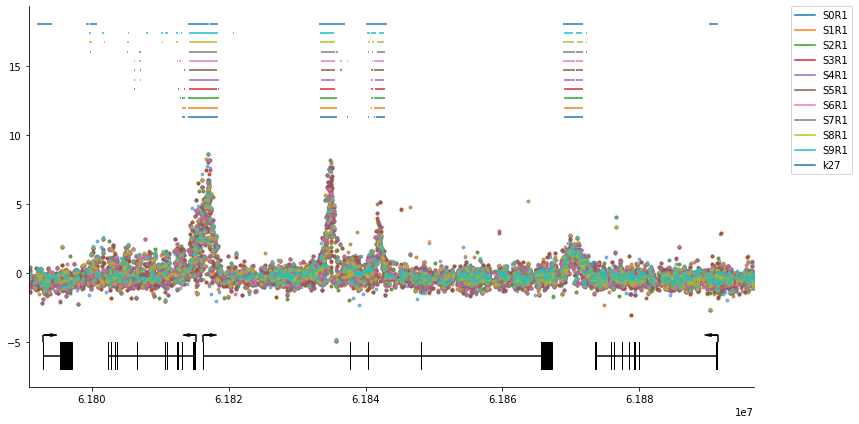

In [55]:
fig_h, ax_h = plot_hff_cutsites(np.array([[61790805,61896817]]), 
                  data, test_peaks, plot_ids=['S0R1','S1R1','S2R1','S3R1','S4R1','S5R1','S6R1','S7R1','S8R1','S9R1','k27'])

draw_genes_from_gff(ax_h, gff)

fig_h.savefig('FADS_locus__subsettingFADS1.pdf')



In [56]:
strong_peaks = test_peaks.loc[test_peaks['assay']=='Sub00'.format(i),('chr','start','end')].values
maxsub_peaks = test_peaks.loc[test_peaks['assay']=='Sub90'.format(i),('chr','start','end')].values
weak_peaks   = maxsub_peaks[ maxsub_peaks[:,2] < strong_peaks[0,1] ]

In [57]:
strong_filter = [ sum(check_overlap(interval[1:3].astype(int), strong_peaks[:,1:3])) > 0 for interval in activ_area ]
weak_filter   = [ sum(check_overlap(interval[1:3].astype(int), weak_peaks[:,1:3])) > 0 for interval in activ_area ]
noPeak_filter = [ sum(check_overlap(interval[1:3].astype(int), weak_peaks[:,1:3])) == 0 for interval in activ_area ]

In [58]:
guide_effect_ = np.concatenate( [data[strong_filter].loc[:,'S0R1'].values, 
                                 data[weak_filter].loc[:,'S0R1'].values,
                                 data[noPeak_filter].loc[:,'S0R1'].values] )
strength_tag_ = np.concatenate( [np.full(shape=sum(strong_filter),fill_value='strong'), 
                                 np.full(shape=sum(weak_filter),fill_value='weak'),
                                 np.full(shape=sum(noPeak_filter),fill_value='inactive')] )

In [59]:
tidy_strength = pd.DataFrame({'activity': guide_effect_, "peak_strength": strength_tag_})

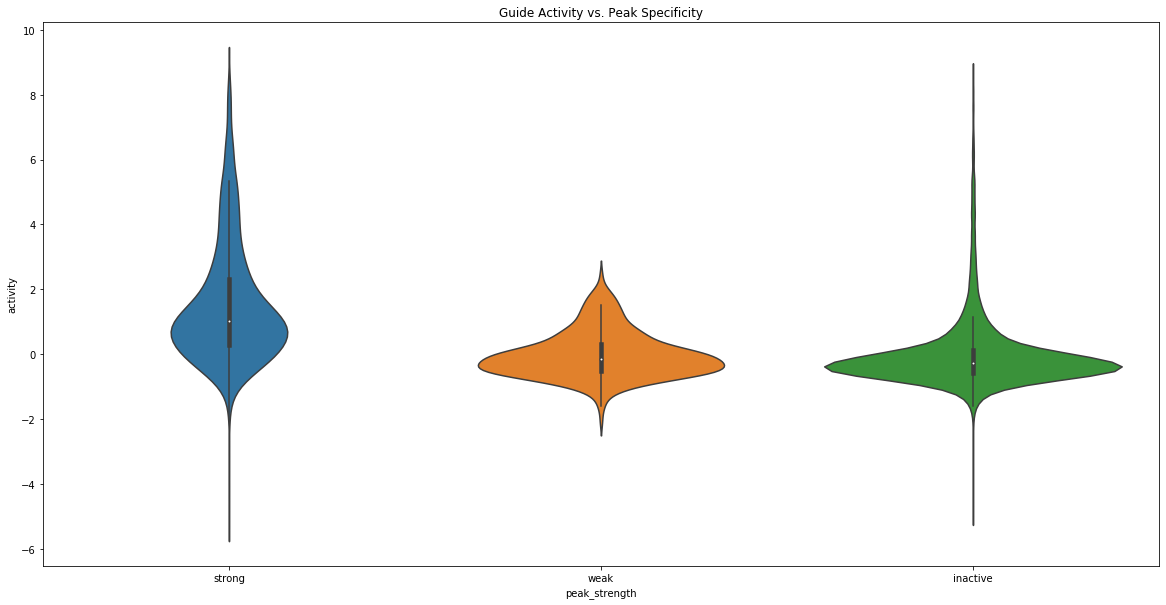

In [60]:
plt.figure(figsize=(20,10))
sns.violinplot(x='peak_strength',y='activity',data=tidy_strength, showfliers = False) \
  .set_title("Guide Activity vs. Peak Specificity");

plt.savefig('guide_score_in_peak_subsets.pdf')

In [61]:
overlap_with_k27ac = []
for i in range(10):
    hold_k27 = test_peaks.loc[test_peaks['assay']=='H3K27ac',('chr','start','end')].values
    hold_sub = test_peaks.loc[test_peaks['assay']=='Sub{}0'.format(i),('chr','start','end')].values
    total_sub_nt = sum(hold_sub[:,2] - hold_sub[:,1])
    inter_sub_nt = sum(intersect_bed3(hold_sub, hold_k27).loc[:,'end'] - intersect_bed3(hold_sub, hold_k27).loc[:,'start'])
    print("{}/{}={}".format(inter_sub_nt,total_sub_nt,inter_sub_nt/total_sub_nt))
    overlap_with_k27ac.append([inter_sub_nt,total_sub_nt])
    

11458/12200=0.9391803278688524
11458/12200=0.9391803278688524
11358/12400=0.9159677419354839
11030/11700=0.9427350427350427
10650/11400=0.9342105263157895
10882/11600=0.9381034482758621
10850/12200=0.889344262295082
10782/12000=0.8985
10545/11800=0.8936440677966102
10499/12900=0.813875968992248


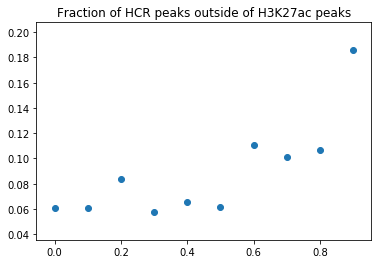

In [62]:
plt.scatter( np.arange(10)/10, [ (y-x)/y for x,y in overlap_with_k27ac ] )

plt.title("Fraction of HCR peaks outside of H3K27ac peaks")

plt.savefig("HCR_Histone_peak_inclusion_w_subsetting.pdf")

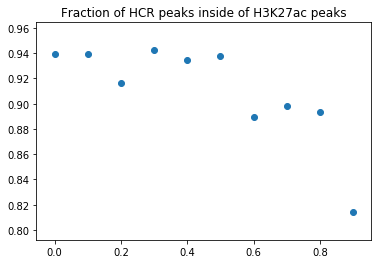

In [63]:
plt.scatter( np.arange(10)/10, [ x/y for x,y in overlap_with_k27ac ] )

plt.title("Fraction of HCR peaks inside of H3K27ac peaks")
plt.savefig("HCR_Histone_peak_exclusion_w_subsetting.pdf")

In [64]:
hold_k27 = test_peaks.loc[test_peaks['assay']=='H3K27ac',('chr','start','end')].values
hold_s10 = test_peaks.loc[test_peaks['assay']=='Sub10',('chr','start','end')].values

In [65]:
hold_k27[ (hold_k27[:,2] > 61815235) & (hold_k27[:,1] < 61871385) ]

array([['chr11', 61813997, 61817089],
       ['chr11', 61817207, 61818398],
       ['chr11', 61833216, 61836978],
       ['chr11', 61840084, 61843199],
       ['chr11', 61868883, 61871778]], dtype=object)

In [66]:
hold_s10

array([['chr11', 61813200, 61813700],
       ['chr11', 61814000, 61818400],
       ['chr11', 61833300, 61835900],
       ['chr11', 61840800, 61841000],
       ['chr11', 61841200, 61842800],
       ['chr11', 61868500, 61868600],
       ['chr11', 61869000, 61871800]], dtype=object)

In [67]:
sum(intersect_bed3(hold_s10, hold_k27).loc[:,'end'] - intersect_bed3(hold_s10, hold_k27).loc[:,'start'])

11458

In [68]:
sum(hold_s10[:,2] - hold_s10[:,1])

12200